In [48]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import requests
from sklearn.linear_model import LinearRegression

In [49]:
# Global Init Variables
GET_TEMPERATURES = False
GET_HUMIDITY = False


In [50]:
# read both observation files
true_observations_df = pd.read_json('../INaturalist_Scraper/Data/true_observations.json')
false_observations_df = pd.read_json('../INaturalist_Scraper/Data/false_observations.json')

# add powdery mildew bool feature for each collection
true_observations_df['PowderyMildew'] = True
false_observations_df['PowderyMildew'] = False

# concat collections
observations_df = pd.concat([true_observations_df, false_observations_df], ignore_index=True)

# Drop rows with missing values
observations_df = observations_df.dropna()

# remove date, we date_string is better
observations_df.drop('date', axis=1, inplace=True)

In [51]:
print(true_observations_df.shape)
print(false_observations_df.shape)

(161, 5)
(164, 5)


In [52]:
# Function to parse date string and extract components
def extract_date_components(date_string):
    import datetime
    # Parse ISO format date string
    dt = datetime.datetime.fromisoformat(date_string.replace('Z', '+00:00'))
    return dt.year, dt.month, dt.day

# Extract relevant data for true observations
lons = []
lats = []
years = []
months = []
days = []

for _, row in observations_df.iterrows():
    lons.append(row['coordinates'][0])
    lats.append(row['coordinates'][1])
    year, month, day = extract_date_components(row['date_string'])
    years.append(year)
    months.append(month)
    days.append(day)
    
observations_df['longitude'] = lons
observations_df['latitude'] = lats
observations_df['year'] = years
observations_df['month'] = months
observations_df['day'] = days

observations_df.sample(10)


,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
249,37350578,2012-04-10T12:01:00-07:00,"[-105.2951145172, 40.0130879924]",False,-105.295115,40.013088,2012,4,10
49,50100800,2020-06-18T16:39:30-04:00,"[-73.9585710504, 40.7722147694]",True,-73.958571,40.772215,2020,6,18
309,22216746,2019-04-09T11:49:14+12:00,"[172.64213996, -43.59530706]",False,172.642140,-43.595307,2019,4,9
147,157576939,2023-04-29T15:50:20+02:00,"[13.3710690778, 52.4881777128]",True,13.371069,52.488178,2023,4,29
146,252172278,2024-11-18T11:29:45-05:00,"[-79.840675, 43.2276883333]",True,-79.840675,43.227688,2024,11,18
314,160174341,2023-04-29T10:54:00+12:00,"[172.6447781167, -43.6027540833]",False,172.644778,-43.602754,2023,4,29
90,248815053,2024-10-24T12:17:02+13:00,"[172.6618684083, -43.3884772042]",True,172.661868,-43.388477,2024,10,24
210,208671153,2024-04-22T11:44:00+02:00,"[14.37787771, 50.07308811]",False,14.377878,50.073088,2024,4,22
138,50784639,2020-06-24T11:06:22-04:00,"[-73.951852033, 40.7703064615]",True,-73.951852,40.770306,2020,6,24
274,176926132,2023-08-05T09:13:00+01:00,"[-0.4093848131, 53.762189945]",False,-0.409385,53.762190,2023,8,5


In [53]:
# Functions to fetch weather data
def get_temps(lon, lat, day, month, year):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)  # make sure is 2 length
    day_str = str(day).zfill(2)      # same as above
    start_date = int(f"{year}{month_str}{day_str}")
    
    parameters = {
        "parameters": "T2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": start_date,
        "format": "JSON"
    }

    response = requests.get(url, params=parameters)
    data = response.json()
    
    temperatures_total = 0
    try:
        for temperature in data['properties']['parameter']['T2M'].values():
            temperatures_total += (temperature * (9/5)) + 32  # convert to Fahrenheit
        temperature_avg = temperatures_total / 24
        return temperature_avg
    except:
        print(f"Error getting temperature data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None

def get_humidity(lon, lat, day, month, year):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    
    month_str = str(month).zfill(2)  # make sure is 2 length
    day_str = str(day).zfill(2)      # same as above
    start_date = int(f"{year}{month_str}{day_str}")
    
    parameters = {
        "parameters": "RH2M",
        "community": "AG",
        "latitude": lat,
        "longitude": lon,
        "start": start_date,
        "end": start_date,
        "format": "JSON"
    }

    response = requests.get(url, params=parameters)
    data = response.json()
    
    humidity_total = 0
    try:
        for humidity in data['properties']['parameter']['RH2M'].values():
            humidity_total += humidity
        humidity_avg = humidity_total / 24
        return humidity_avg
    except:
        print(f"Error getting humidity data for {year}-{month_str}-{day_str} at {lat},{lon}")
        return None

In [54]:
# Add temperature data to dataframe and save 

if GET_TEMPERATURES:

    # Call get_temps for each row
    temperatures = []
    for i, row in observations_df.iterrows():
        temp = get_temps(row['longitude'], row['latitude'], row['day'], row['month'], row['year'])
        temperatures.append(temp)
        
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")

    # Add temps to dataframe
    observations_df['Temp'] = temperatures

    # Drop empty rows
    observations_df = observations_df.dropna(subset=['Temp'])

    # Save to CSV file
    observations_df.to_csv('observations_with_temps.csv', index=False)
    print(f"Saved processed dataframe with {len(observations_df)} observations to observations_with_temps.csv")
    
if GET_HUMIDITY:
    
        # Call get_temps for each row
    humidities = []
    for i, row in observations_df.iterrows():
        humidity = get_humidity(row['longitude'], row['latitude'], row['day'], row['month'], row['year'])
        humidities.append(humidity)
        
        # Print progress every 10 rows
        if i % 10 == 0:
            print(f"Processed {i}")

    # Add temps to dataframe
    observations_df['Humidity'] = humidities

    # Drop empty rows
    observations_df = observations_df.dropna(subset=['Humidity'])

    # Save to CSV file
    observations_df.to_csv('observations_with_humidity.csv', index=False)
    print(f"Saved processed dataframe with {len(observations_df)} observations to observations_with_humidity.csv")


In [55]:
observations_df.head()

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6
1,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10
2,169576529,2023-06-26T09:10:01+02:00,"[8.80802725, 50.8119201389]",True,8.808027,50.811920,2023,6,26
3,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9
5,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19


In [56]:
hum_df = pd.read_csv('observations_with_humidity.csv')
hum_df.head()

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Humidity
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,78.492917
1,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,82.803750
2,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,78.535417
3,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,58.924167
4,161092221,2023-05-11T15:45:23+01:00,"[-0.3697666526, 53.7434492925]",True,-0.369767,53.743449,2023,5,11,88.689583


In [57]:
temp_df = pd.read_csv('observations_with_temps.csv')
temp_df.head()

,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Temp
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,72.44525
1,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,59.26250
2,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,53.86175
3,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,52.54100
4,161092221,2023-05-11T15:45:23+01:00,"[-0.3697666526, 53.7434492925]",True,-0.369767,53.743449,2023,5,11,52.53050


In [58]:
# Perform the merge
weather_df = pd.merge(hum_df, temp_df, on=['id'], how='inner')

# Select the columns to keep
columns_to_keep = [
    'id', 'date_string_x', 'coordinates_x', 'PowderyMildew_x', 'longitude_x', 'latitude_x', 
    'year_x', 'month_x', 'day_x', 'Humidity', 'Temp'
]

# Create the final DataFrame with the selected columns
weather_df = weather_df[columns_to_keep]

# Rename columns for clarity
weather_df = weather_df.rename(columns={
    'date_string_x': 'date_string',
    'coordinates_x': 'coordinates',
    'PowderyMildew_x': 'PowderyMildew',
    'longitude_x': 'longitude',
    'latitude_x': 'latitude',
    'year_x': 'year',
    'month_x': 'month',
    'day_x': 'day'
})

# Display the cleaned DataFrame
weather_df.head()



,id,date_string,coordinates,PowderyMildew,longitude,latitude,year,month,day,Humidity,Temp
0,48688154,2020-06-06T14:17:01-04:00,"[-73.9520673641, 40.7700205967]",True,-73.952067,40.770021,2020,6,6,78.492917,72.44525
1,206356226,2024-04-09T19:08:00-04:00,"[-76.3073433611, 38.9860498889]",True,-76.307343,38.986050,2024,4,9,82.803750,59.26250
2,162498461,2023-05-19T16:44:24+02:00,"[12.9216153547, 48.6943073404]",True,12.921615,48.694307,2023,5,19,78.535417,53.86175
3,116476822,2022-05-10T16:37:09-04:00,"[-73.95191313710001, 40.7701800205]",True,-73.951913,40.770180,2022,5,10,58.924167,52.54100
4,161092221,2023-05-11T15:45:23+01:00,"[-0.3697666526, 53.7434492925]",True,-0.369767,53.743449,2023,5,11,88.689583,52.53050


In [59]:
# Filter weather_df to only keep rows where id is in observations_df
weather_df = weather_df[weather_df['id'].isin(observations_df['id'])]

# # Display the filtered DataFrame
# print(f"Number of rows after filtering: {len(weather_df)}")
# weather_df.head()

weather_df.shape


(318, 11)

In order to decrease relationships between variables (such as the connections and potential spurrious correlations between powdery mildew and date_string, month, and day) we can combine this date information into one number: the day of the calendar year 1-365.

Likewise, we can also get rid of the coordinates column for our model, because that information is stored within longitude and latitude. We also don't want our model using the id of each picture. 

In [60]:
# Function to calculate the day of the year
def calculate_day_of_year(row):
    date = datetime.datetime(row['year'], row['month'], row['day'])
    return date.timetuple().tm_yday

# Create a copy of the original DataFrame to keep it intact
updated_weather_df = weather_df.copy()

# Apply the function to create the new column
updated_weather_df['day_of_year'] = updated_weather_df.apply(calculate_day_of_year, axis=1)

# Drop the specified columns
columns_to_drop = ['date_string', 'coordinates', 'month', 'day', 'id']
updated_weather_df = updated_weather_df.drop(columns=columns_to_drop)

# Select the columns to keep in the final DataFrame
columns_to_keep = ['PowderyMildew', 'longitude', 'latitude', 'day_of_year', 'Temp', 'Humidity']
updated_weather_df = updated_weather_df[columns_to_keep]

# Display the updated DataFrame
updated_weather_df.head()


,PowderyMildew,longitude,latitude,day_of_year,Temp,Humidity
0,True,-73.952067,40.770021,158,72.44525,78.492917
1,True,-76.307343,38.986050,100,59.26250,82.803750
2,True,12.921615,48.694307,139,53.86175,78.535417
3,True,-73.951913,40.770180,130,52.54100,58.924167
4,True,-0.369767,53.743449,131,52.53050,88.689583


Now we are ready to build a regression tree using this updated data frame!

Accuracy: 0.65625
Classification Report:
              precision    recall  f1-score   support

       False       0.65      0.65      0.65        31
        True       0.67      0.67      0.67        33

    accuracy                           0.66        64
   macro avg       0.66      0.66      0.66        64
weighted avg       0.66      0.66      0.66        64



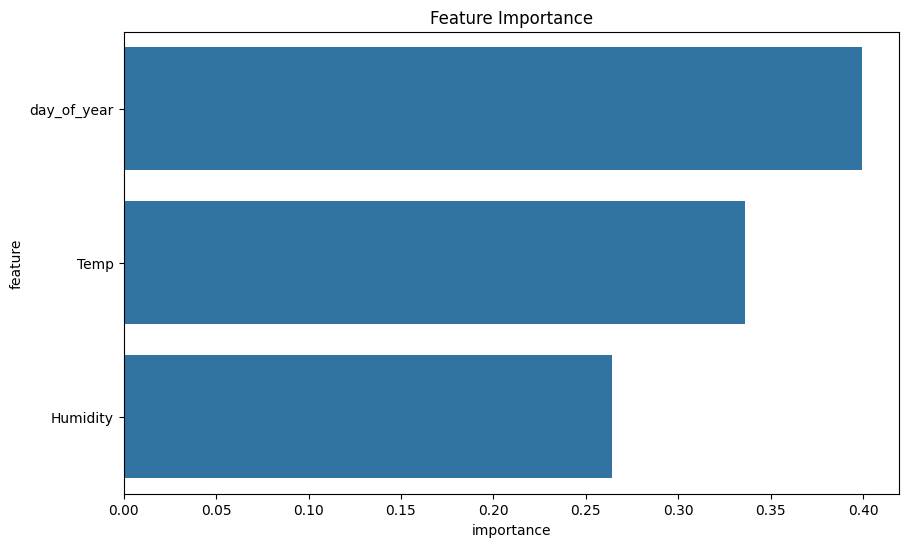

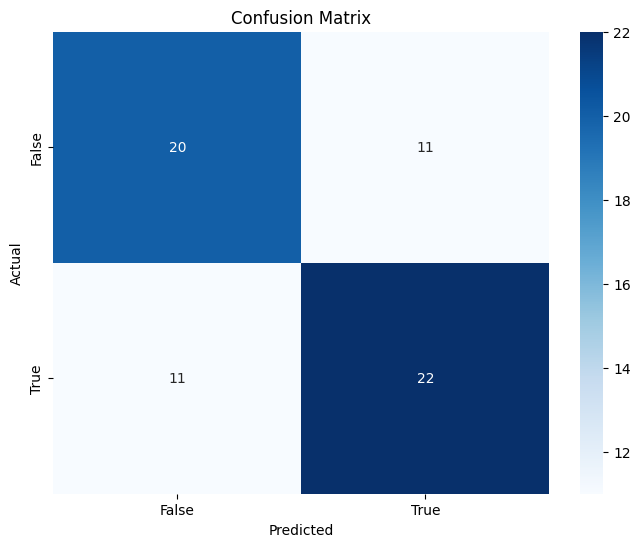

In [61]:
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features and target variable
features = ['day_of_year', 'Temp', 'Humidity']
target = 'PowderyMildew'

X = updated_weather_df[features]
y = updated_weather_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



The overall accuracy is very high, likely overfit for the amount of data that we have. The bar chart (first graph) shows that the location of the picture is the most important predictor. This likely means that our data is too niche with LOTS of entries in NY and WA State, introducing bias. Lastly, the confusion matrix shows that out model is very good at detecting where PM is unlikely, but not very good at finding it (see the 0.37 recall score for True)